In [1]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import csv
import math
import scipy

import dataset
import datasplit
import model.models as models
import trainer
import utils

In [2]:
# LOAD
# folders
models_folder = 'G:/PracaMagisterska/Kod_na_magisterke/gfx-classifier_RNN_version-models_and_results/models'
model_name = '20201018_setnetcond_poly_disc_best'
results_folder = 'G:/PracaMagisterska/Kod_na_magisterke/gfx-classifier_RNN_version-models_and_results/result'
results_subfolder = '20201018_setnetcond_poly_disc'

# load model
setnetcond = torch.load('%s/%s' % (models_folder, model_name), map_location=torch.device('cpu'))

# load results
all_train_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_losses.npy')), allow_pickle=True)
all_train_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_correct.npy')), allow_pickle=True)
best_train_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_train_results.npy')), allow_pickle=True)

all_val_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_losses.npy')), allow_pickle=True)
all_val_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_correct.npy')), allow_pickle=True)
best_val_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_val_results.npy')), allow_pickle=True)

all_test_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_losses.npy')), allow_pickle=True)
all_test_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_correct.npy')), allow_pickle=True)
best_test_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_test_results.npy')), allow_pickle=True)

fx_labels = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'fx_labels.npy')), allow_pickle=True)

# datasets sizes
train_set_size = best_train_results.shape[0]
val_set_size = best_val_results.shape[0]
test_set_size = best_test_results.shape[0]

# example
best_train_results[0]

C:\Users\maszy\AppData\Local\Temp\ipykernel_22284\122697889.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  setnetcond = torch.load('%s/%s' % (models_folder, model_name)

array([5023, 'P94-48170-808-O10T5-41490',
       array([1.   , 1.   , 0.509], dtype=float32),
       array([1. , 1. , 0.5], dtype=float32)], dtype=object)

Best Train Accuracy:  97.37787056367432
Epoch:  63

Best Val Accuracy:  94.39350668871185
Epoch:  55

Test Accuracy:  94.09571909571909
Epoch:  55



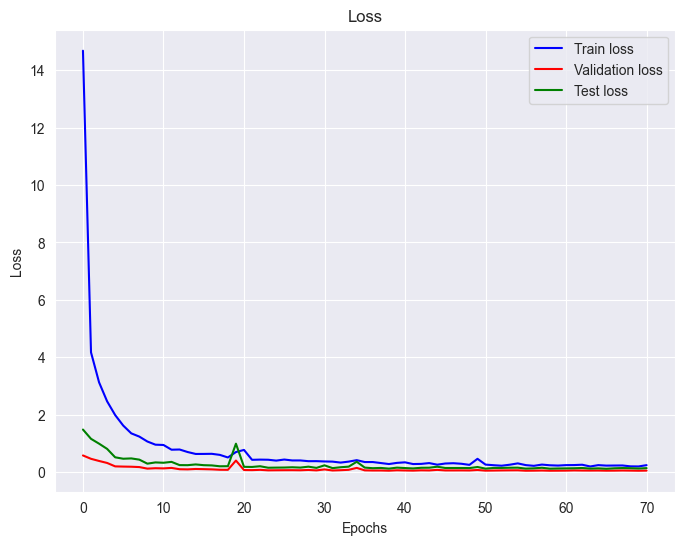

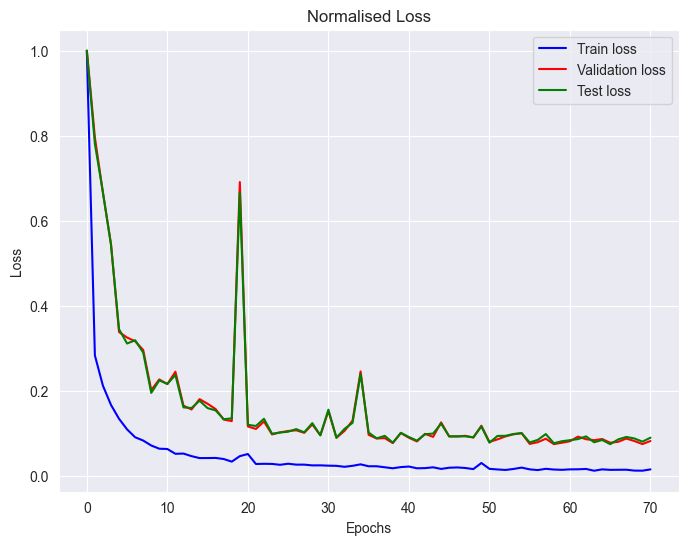

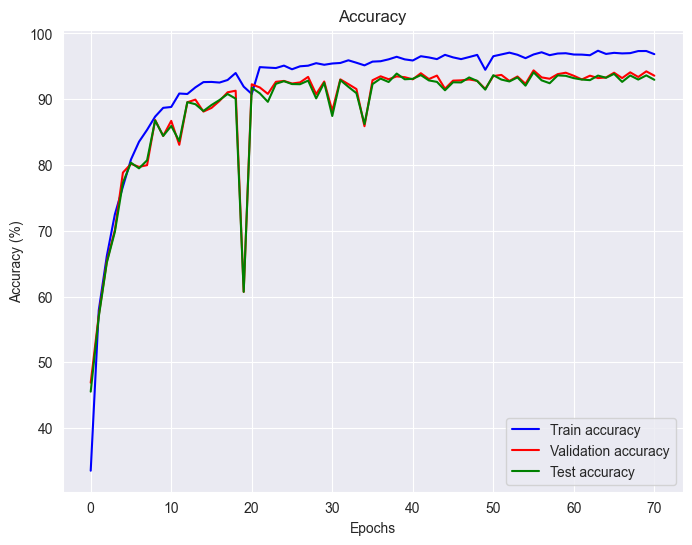

In [3]:
# Ustawienie ścieżki do zapisu
save_path = 'G:/PracaMagisterska/Kod_na_magisterke/gfx-classifier_RNN_version-models_and_results/result/figures/Setnetcond_poly_disc_plots'

# BEST RESULTS
print('Best Train Accuracy: ', 100 * max(all_train_correct) / train_set_size)
print('Epoch: ', np.argmax(all_train_correct))
print()
print('Best Val Accuracy: ', 100 * max(all_val_correct) / val_set_size)
print('Epoch: ', np.argmax(all_val_correct))
print()
print('Test Accuracy: ', 100 * max(all_test_correct) / test_set_size)
print('Epoch: ', np.argmax(all_test_correct))
print()

# LOSS
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(True)  # Włącza siatkę
plt.plot(epochs, all_train_losses, 'b', label='Train loss')
plt.plot(epochs, all_val_losses, 'r', label='Validation loss')
plt.plot(epochs, all_test_losses, 'g', label='Test loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{save_path}/loss_plot.jpeg', format='jpeg')  # Zapisuje wykres w formacie JPEG
plt.show()

# NORMALISED LOSS
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(True)  # Włącza siatkę
plt.plot(epochs, np.array(all_train_losses) / max(all_train_losses), 'b', label='Train loss')
plt.plot(epochs, np.array(all_val_losses) / max(all_val_losses), 'r', label='Validation loss')
plt.plot(epochs, np.array(all_test_losses) / max(all_test_losses), 'g', label='Test loss')
plt.title('Normalised Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{save_path}/normalised_loss_plot.jpeg', format='jpeg')  # Zapisuje wykres w formacie JPEG
plt.show()

# ACCURACY
all_train_perc_correct = 100 * np.array(all_train_correct) / train_set_size
all_val_perc_correct = 100 * np.array(all_val_correct) / val_set_size
all_test_perc_correct = 100 * np.array(all_test_correct) / test_set_size
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(True)  # Włącza siatkę
plt.plot(epochs, all_train_perc_correct, 'b', label='Train accuracy')
plt.plot(epochs, all_val_perc_correct, 'r', label='Validation accuracy')
plt.plot(epochs, all_test_perc_correct, 'g', label='Test accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig(f'{save_path}/accuracy_plot.jpeg', format='jpeg')  # Zapisuje wykres w formacie JPEG
plt.show()

In [4]:
# DATAFRAME
test_indexes_poly_disc = best_test_results[:, 0]
test_filenames_poly_disc = best_test_results[:, 1] 
test_preds_poly_disc = np.stack(best_test_results[:, 2])
test_targets_poly_disc = np.stack(best_test_results[:, 3])
test_abs_err_poly_disc = np.stack(abs(test_preds_poly_disc - test_targets_poly_disc))
test_err_poly_disc = np.stack(test_preds_poly_disc - test_targets_poly_disc)

test_df_poly_disc = pd.DataFrame(data={
    'index': test_indexes_poly_disc, 
    'filename': test_filenames_poly_disc,
    'level_pred': test_preds_poly_disc[:,0], 
    'gain_pred': test_preds_poly_disc[:,1],
    'tone_eq1_pred': test_preds_poly_disc[:,2], 
    'level_targ': test_targets_poly_disc[:,0], 
    'gain_targ': test_targets_poly_disc[:,1],
    'tone_eq1_targ': test_targets_poly_disc[:,2], 
    'level_err': test_err_poly_disc[:,0], 
    'gain_err': test_err_poly_disc[:,1],
    'tone_eq1_err': test_err_poly_disc[:,2], 
    'level_abs': test_abs_err_poly_disc[:,0], 
    'gain_abs': test_abs_err_poly_disc[:,1],
    'tone_eq1_abs': test_abs_err_poly_disc[:,2], 
})

print(len(test_df_poly_disc))
test_df_poly_disc[:3]

16632


,index,filename,level_pred,gain_pred,tone_eq1_pred,level_targ,gain_targ,tone_eq1_targ,level_err,gain_err,tone_eq1_err,level_abs,gain_abs,tone_eq1_abs
0,23055,P94-57150-BMF-S8T0-41469,1.0,0.814,0.002,1.0,0.8,0.0,0.0,0.014,0.002,0.0,0.014,0.002
1,36463,P94-46160-FFC-F5-41473,1.0,0.207,-1.000,1.0,0.5,-1.0,0.0,-0.293,0.000,0.0,0.293,0.000
2,44931,P95-51270-MGS-D5T10-41598,1.0,0.505,0.999,1.0,0.5,1.0,0.0,0.005,-0.001,0.0,0.005,0.001


In [5]:
# MAE
level_mae_poly = sum(test_df_poly_disc.level_abs)/test_set_size
gain_mae_poly = sum(test_df_poly_disc.gain_abs)/test_set_size
tone_eq1_mae_poly = sum(test_df_poly_disc.tone_eq1_abs)/test_set_size

print('level_mae: ', level_mae_poly)
print('gain_mae: ', gain_mae_poly)
print('tone_eq1_mae: ', tone_eq1_mae_poly)

# RMSE
level_rmse_poly = math.sqrt(sum(test_df_poly_disc.level_abs**2)/test_set_size)
gain_rmse_poly = math.sqrt(sum(test_df_poly_disc.gain_abs**2)/test_set_size)
tone_eq1_rmse_poly = math.sqrt(sum(test_df_poly_disc.tone_eq1_abs**2)/test_set_size)

print('level_rmse: ', level_rmse_poly)
print('gain_rmse: ', gain_rmse_poly)
print('tone_eq1_rmse: ', tone_eq1_rmse_poly)

level_mae:  0.0
gain_mae:  0.012112914091883812
tone_eq1_mae:  0.018773869984381072
level_rmse:  0.0
gain_rmse:  0.029764540047517603
tone_eq1_rmse:  0.04181112765915846


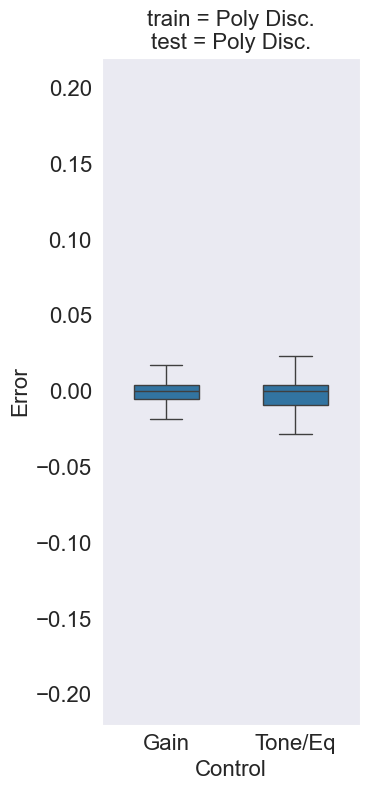

In [6]:
# BOX PLOT
err_df_poly_disc = pd.DataFrame(data={
    'Gain': test_df_poly_disc['gain_err'],
    'Tone/Eq': test_df_poly_disc['tone_eq1_err'],
})

plt.figure(figsize=(3.8,8))
plt.grid(False)
ax = utils.box_plot(error_dataframe=err_df_poly_disc, title='train = Poly Disc.\ntest = Poly Disc.', title_fontsize=16, text_fontsize=16)
ax.set(ylim=(-0.22,0.22))
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_bp_PD_PD.eps'), format='eps')

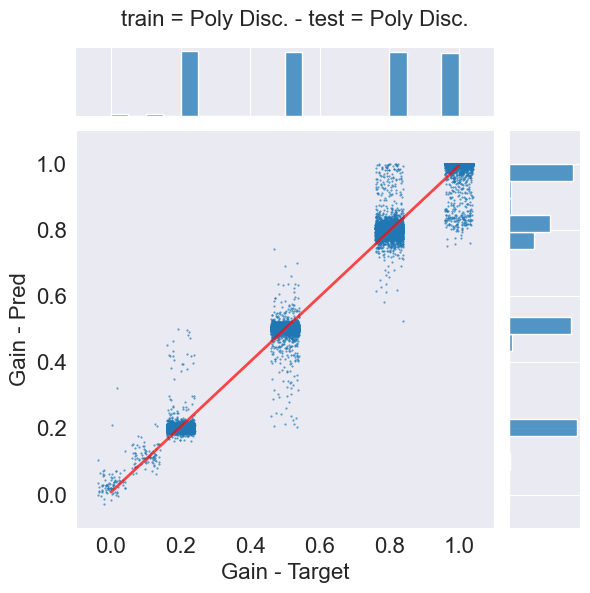

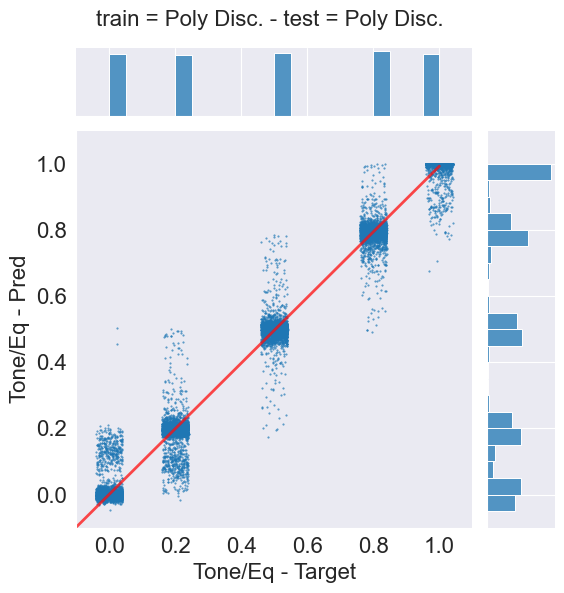

In [7]:
# SCATTER PLOT
# gain
ax = utils.scatter_plot(
    x="gain_targ", y="gain_pred", dataframe=test_df_poly_disc, 
    title='train = Poly Disc. - test = Poly Disc.', title_fontsize=16, 
    text_fontsize=16, xlabel='Gain - Target', ylabel='Gain - Pred'
)

ax.ax_marg_x.set_xlim(-0.1, 1.1)
ax.ax_marg_y.set_ylim(-0.1, 1.1)
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_sp_gain_PD_PD.jpg'), dpi=500, format='jpg')

# tone/eq1
ax = utils.scatter_plot(
    x="tone_eq1_targ", y="tone_eq1_pred", dataframe=test_df_poly_disc, 
    title='train = Poly Disc. - test = Poly Disc.', title_fontsize=16, 
    text_fontsize=16, xlabel='Tone/Eq - Target', ylabel='Tone/Eq - Pred',
    bins=40
)

ax.ax_marg_x.set_xlim(-0.1, 1.1)
ax.ax_marg_y.set_ylim(-0.1, 1.1)
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_sp_tone_PD_PD.jpg'), dpi=500, format='jpg')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


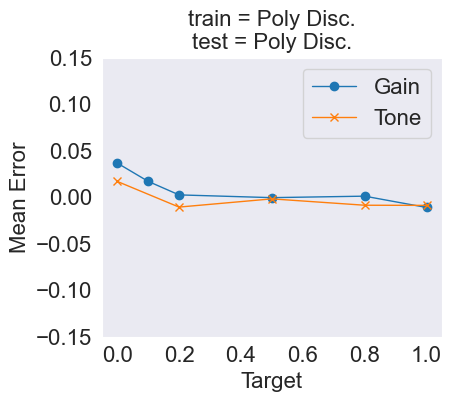

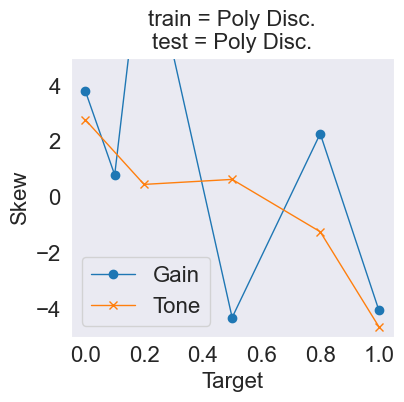

In [8]:
# MEAN ERROR and SKEW PLOTS
steps_gain = [0.0, 0.1, 0.2, 0.5, 0.8, 1.0]
steps_tone = [0.0, 0.2, 0.5, 0.8, 1.0]
avg_err_gain = []
avg_err_tone = []
skew_gain = []
skew_tone = []

for n in range(len(steps_gain)):
    df = test_df_poly_disc[test_df_poly_disc['gain_targ'] == steps_gain[n]]
    avg_err_gain.append(sum(df['gain_err']) / len(df))
    skew_gain.append(scipy.stats.skew(df['gain_err']))

for n in range(len(steps_tone)):
    df = test_df_poly_disc[test_df_poly_disc['tone_eq1_targ'] == steps_tone[n]]
    avg_err_tone.append(sum(df['tone_eq1_err']) / len(df))
    skew_tone.append(scipy.stats.skew(df['tone_eq1_err']))

# print(np.around(avg_err_gain,3))
# print(np.around(avg_err_tone,3))
# print(np.around(skew_gain,3))
# print(np.around(skew_tone,3))

# mean error
plt.figure(figsize=(4.8,4.3))
utils.line_plot(
    x_gain=steps_gain, x_tone=steps_tone, 
    y_gain=avg_err_gain, y_tone=avg_err_tone, 
    title='train = Poly Disc.\ntest = Poly Disc.' , title_fontsize=16, 
    text_fontsize=16, xlabel='Target', ylabel='Mean Error'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.15, 0.15])
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_me_PD_PD.eps'), format='eps')

# skew
plt.figure(figsize=(4.5,4.3))
ax = utils.line_plot(
    x_gain=steps_gain, x_tone=steps_tone, 
    y_gain=skew_gain, y_tone=skew_tone, 
    title='train = Poly Disc.\ntest = Poly Disc.' , title_fontsize=16, 
    text_fontsize=16, xlabel='Target', ylabel='Skew'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-5, 5])
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_sk_PD_PD.eps'), format='eps')

# TEST on POLY CONTINUOUS

In [9]:
# PREPARE
# dataset
dataset_poly_cont = dataset.FxDataset(
    root='G:/PracaMagisterska/Dane/Poly_Continuous_Audio',
    excl_folders=['MT2'], 
    spectra_folder='mel_22050_1024_512', 
    processed_settings_csv='proc_settings.csv',
    max_num_settings=3,
    transform=transforms.Compose([transforms.ToTensor()])
)

# initialise
dataset_poly_cont.init_dataset()
# generate features - necessary only the first time
# dataset_mono_cont.generate_mel()

# split
# set test_train_split=0.0 and val_train_split=0.0 to test pre-trained model
split_poly_cont = datasplit.DataSplit(dataset_poly_cont, test_train_split=0.0, val_train_split=0.0, shuffle=True)

# loaders
_, _, test_loader_poly_cont = split_poly_cont.get_split(batch_size=100)

len(dataset_poly_cont)

130000

In [10]:
# TEST
test_poly_cont_loss, test_poly_cont_correct, test_poly_cont_results = trainer.test_settings_cond_net(
        model=setnetcond, 
        test_loader=test_loader_poly_cont, 
        test_sampler=split_poly_cont.test_sampler,
        loss_function=nn.MSELoss(), 
        device='cpu'
    )

# example
test_poly_cont_results[0]

====> Test Loss: 4.3339	 Avg Loss: 0.0000	Correct: 95361/130000	Percentage Correct: 73.35


(40605,
 'P64-47110-DS1-D2.5T7.8-41189',
 array([1.   , 0.212, 0.674], dtype=float32),
 array([1.  , 0.25, 0.78], dtype=float32))

In [11]:
# Wyodrębnij poszczególne elementy z listy
test_indexes_poly_cont = [item[0] for item in test_poly_cont_results]
test_filenames_poly_cont = [item[1] for item in test_poly_cont_results]
test_preds_poly_cont = np.vstack([item[2] for item in test_poly_cont_results])
test_targets_poly_cont = np.vstack([item[3] for item in test_poly_cont_results])

# Oblicz błędy
test_abs_err_poly_cont = np.abs(test_preds_poly_cont - test_targets_poly_cont)
test_err_poly_cont = test_preds_poly_cont - test_targets_poly_cont

# Utwórz DataFrame
test_df_poly_cont = pd.DataFrame(data={
    'index': test_indexes_poly_cont, 
    'filename': test_filenames_poly_cont,
    'level_pred': test_preds_poly_cont[:, 0], 
    'gain_pred': test_preds_poly_cont[:, 1],
    'tone_eq1_pred': test_preds_poly_cont[:, 2], 
    'level_targ': test_targets_poly_cont[:, 0], 
    'gain_targ': test_targets_poly_cont[:, 1],
    'tone_eq1_targ': test_targets_poly_cont[:, 2], 
    'level_err': test_err_poly_cont[:, 0], 
    'gain_err': test_err_poly_cont[:, 1],
    'tone_eq1_err': test_err_poly_cont[:, 2], 
    'level_abs': test_abs_err_poly_cont[:, 0], 
    'gain_abs': test_abs_err_poly_cont[:, 1],
    'tone_eq1_abs': test_abs_err_poly_cont[:, 2], 
})

print(len(test_df_poly_cont))
print(test_df_poly_cont.head(3))


130000
   index                      filename  level_pred  gain_pred  tone_eq1_pred  \
0  40605  P64-47110-DS1-D2.5T7.8-41189         1.0      0.212          0.674   
1  63775  P65-50250-MGS-D6.5T7.3-41357         1.0      0.709          0.758   
2  53131      P65-47210-FFC-F5.3-41294         1.0      0.522         -1.000   

   level_targ  gain_targ  tone_eq1_targ  level_err  gain_err  tone_eq1_err  \
0         1.0       0.25           0.78        0.0    -0.038        -0.106   
1         1.0       0.66           0.73        0.0     0.049         0.028   
2         1.0       0.53          -1.00        0.0    -0.008         0.000   

   level_abs  gain_abs  tone_eq1_abs  
0        0.0     0.038         0.106  
1        0.0     0.049         0.028  
2        0.0     0.008         0.000  


In [12]:
# MAE
level_mae_poly_cont = sum(test_df_poly_cont.level_abs)/len(dataset_poly_cont)
gain_mae_poly_cont = sum(test_df_poly_cont.gain_abs)/len(dataset_poly_cont)
tone_eq1_mae_poly_cont = sum(test_df_poly_cont.tone_eq1_abs)/len(dataset_poly_cont)

print('level_mae: ', level_mae_poly_cont)
print('gain_mae: ', gain_mae_poly_cont)
print('tone_eq1_mae: ', tone_eq1_mae_poly_cont)

# RMSE
level_rmse_poly_cont = math.sqrt(sum(test_df_poly_cont.level_abs**2)/len(dataset_poly_cont))
gain_rmse_poly_cont = math.sqrt(sum(test_df_poly_cont.gain_abs**2)/len(dataset_poly_cont))
tone_eq1_rmse_poly_cont = math.sqrt(sum(test_df_poly_cont.tone_eq1_abs**2)/len(dataset_poly_cont))

print('level_rmse: ', level_rmse_poly_cont)
print('gain_rmse: ', gain_rmse_poly_cont)
print('tone_eq1_rmse: ', tone_eq1_rmse_poly_cont)

level_mae:  3.076883462759165e-08
gain_mae:  0.058626814972061236
tone_eq1_mae:  0.039910407267164334
level_rmse:  5.546930694606405e-06
gain_rmse:  0.07603520663376291
tone_eq1_rmse:  0.06496567838334703


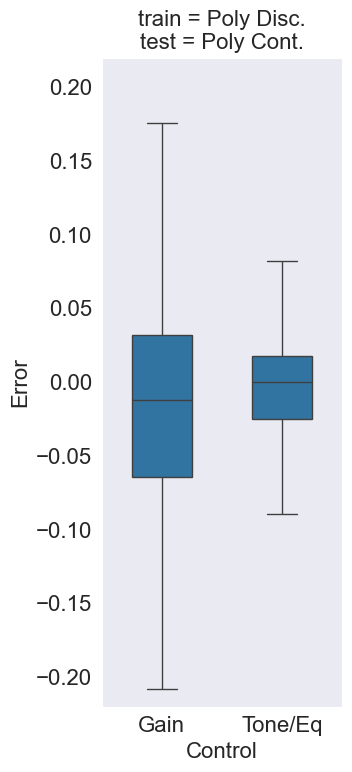

In [20]:
# BOX PLOT
err_df_poly_cont = pd.DataFrame(data={
    'Gain': test_df_poly_cont['gain_err'],
    'Tone/Eq': test_df_poly_cont['tone_eq1_err'],
})

plt.figure(figsize=(3.8,8))
plt.grid(False)
ax = utils.box_plot(error_dataframe=err_df_poly_cont, title='train = Poly Disc.\ntest = Poly Cont.', title_fontsize=16, text_fontsize=16)
ax.set(ylim=(-0.22,0.22))
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_bp_PD_PC.eps'), format='eps')

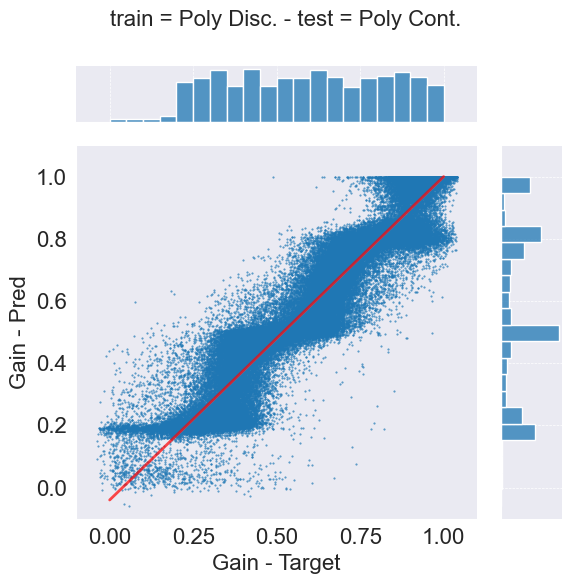

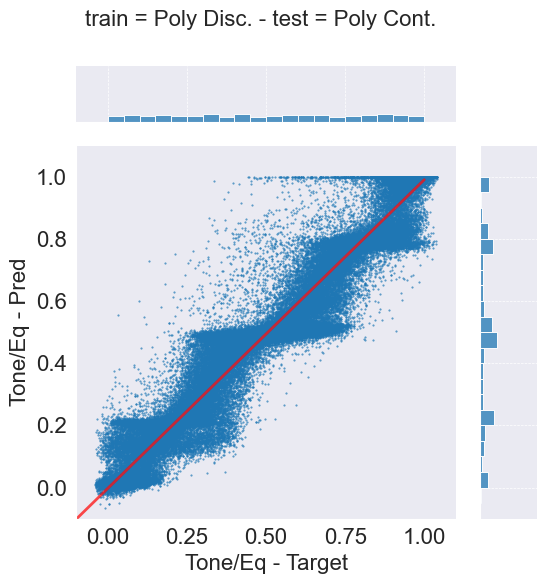

In [14]:
# SCATTER PLOT
# gain
ax = utils.scatter_plot(
    x="gain_targ", y="gain_pred", dataframe=test_df_poly_cont, 
    title='train = Poly Disc. - test = Poly Cont.', title_fontsize=16, 
    text_fontsize=16, xlabel='Gain - Target', ylabel='Gain - Pred'
)

ax.ax_marg_x.set_xlim(-0.1, 1.1)
ax.ax_marg_y.set_ylim(-0.1, 1.1)
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_sp_gain_PD_PC.png'), format='png')
# 
# tone/eq1
ax = utils.scatter_plot(
    x="tone_eq1_targ", y="tone_eq1_pred", dataframe=test_df_poly_cont, 
    title='train = Poly Disc. - test = Poly Cont.', title_fontsize=16, 
    text_fontsize=16, xlabel='Tone/Eq - Target', ylabel='Tone/Eq - Pred',
    bins=40
)

ax.ax_marg_x.set_xlim(-0.1, 1.1)
ax.ax_marg_y.set_ylim(-0.1, 1.1)
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_sp_tone_PD_PC.png'), format='png')

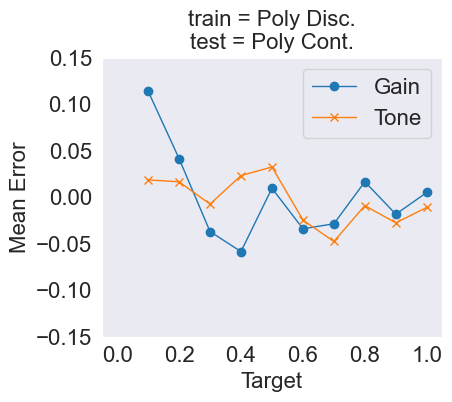

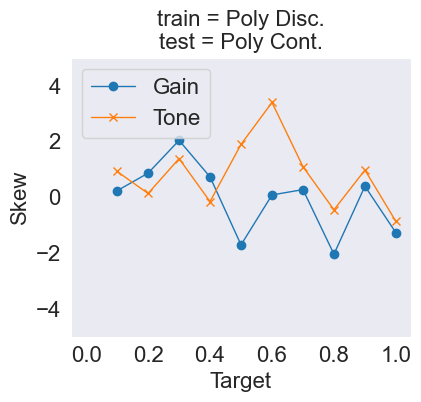

In [15]:
# MEAN ERROR and SKEW PLOTS
step_size = 0.1
steps = np.linspace(start=0, stop=1, num=int(1/step_size + 1))
avg_err_gain = []
avg_err_tone = []
skew_gain = []
skew_tone = []

for n in range(len(steps)-1):
    df = test_df_poly_cont[(test_df_poly_cont['gain_targ'] >= steps[n]) & (test_df_poly_cont['gain_targ'] < steps[n+1])]
    avg_err_gain.append(sum(df['gain_err']) / len(df))
    skew_gain.append(scipy.stats.skew(df['gain_err']))

for n in range(len(steps)-1):
    df = test_df_poly_cont[(test_df_poly_cont['tone_eq1_targ'] >= steps[n]) & (test_df_poly_cont['tone_eq1_targ'] < steps[n+1])]
    avg_err_tone.append(sum(df['tone_eq1_err']) / len(df))
    skew_tone.append(scipy.stats.skew(df['tone_eq1_err']))

# print(np.around(avg_err_gain,3))
# print(np.around(avg_err_tone,3))

# mean error
plt.figure(figsize=(4.8,4.3))
utils.line_plot(
    x_gain=steps[1:], x_tone=steps[1:], 
    y_gain=avg_err_gain, y_tone=avg_err_tone, 
    title='train = Poly Disc.\ntest = Poly Cont.' , title_fontsize=16, 
    text_fontsize=16, xlabel='Target', ylabel='Mean Error'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.15, 0.15])
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_me_PD_PC.eps'), format='eps')

# skew
plt.figure(figsize=(4.5,4.3))
ax = utils.line_plot(
    x_gain=steps[1:], x_tone=steps[1:], 
    y_gain=skew_gain, y_tone=skew_tone, 
    title='train = Poly Disc.\ntest = Poly Cont.' , title_fontsize=16, 
    text_fontsize=16, xlabel='Target', ylabel='Skew'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-5, 5])
plt.grid(False)
plt.savefig('%s/%s/%s' % (results_folder, 'figures', 'setnetcond_sk_PD_PC.eps'), format='eps')